In [1]:
import nibabel as nib
from nilearn import datasets, input_data, plotting, connectome, image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, zscore
import pandas as pd



In [2]:
# Specify the path to your fMRI data
fmri_path1 = '/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_datasets/ds002837/sub-1/func/sub-1_task-500daysofsummer_run-01_bold.nii.gz'
fmri_path2 = '/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_datasets/ds002837/sub-1/func/sub-1_task-500daysofsummer_run-02_bold.nii.gz'
fmri_path3 = '/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_datasets/ds002837/sub-1/func/sub-1_task-500daysofsummer_run-03_bold.nii.gz'
combined_image = image.concat_imgs([fmri_path1, fmri_path2, fmri_path3])

img1 = nib.load(fmri_path1)
img2 = nib.load(fmri_path2)
img3 = nib.load(fmri_path3)
img1.shape, img2.shape, img3.shape, combined_image.shape

((64, 64, 40, 185), (64, 64, 40, 3307), (64, 64, 40, 1997), (64, 64, 40, 5489))

In [3]:
# Load the NIfTI file
zooms = img1.header.get_zooms() 

# Print each element in the zooms tuple
print(f"Voxel size along x-axis: {zooms[0]} mm")
print(f"Voxel size along y-axis: {zooms[1]} mm")
print(f"Voxel size along z-axis: {zooms[2]} mm")
print(f"Repetition Time (TR): {zooms[3]} seconds") # The TR is typically the 4th element in the zooms tuple

Voxel size along x-axis: 3.203125 mm
Voxel size along y-axis: 3.203125 mm
Voxel size along z-axis: 3.200000047683716 mm
Repetition Time (TR): 1.0 seconds


### Global Connectome

In [4]:
# Use a predefined atlas from Nilearn (e.g., Harvard-Oxford atlas)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
#subcortical_atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm') precisa adicionar o subcortical_atlas
atlas_img = atlas.maps
labels = atlas.labels
print(labels)

# Define the masker to extract time series from ROIs
masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)

# Extract time series data
time_series1 = masker.fit_transform(img1)
time_series2 = masker.fit_transform(img2)
time_series3 = masker.fit_transform(img3)
print(time_series1.shape,time_series2.shape,time_series3.shape)


['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

support or moderation of cognitive reappraisal: the bilateral inferior frontal gyrus, middle frontal gyrus, superior parietal lobe, amygdala, right medial frontal gyrus, left anterior cingulate gyrus, left anterior insula, left superior temporal gyrus and left middle temporal gyrus

In [5]:
# Concatenate time series from multiple runs
time_series1,time_series2,time_series3
time_series = np.concatenate((time_series1, time_series2, time_series3), axis=0)
time_series.shape

(5489, 48)

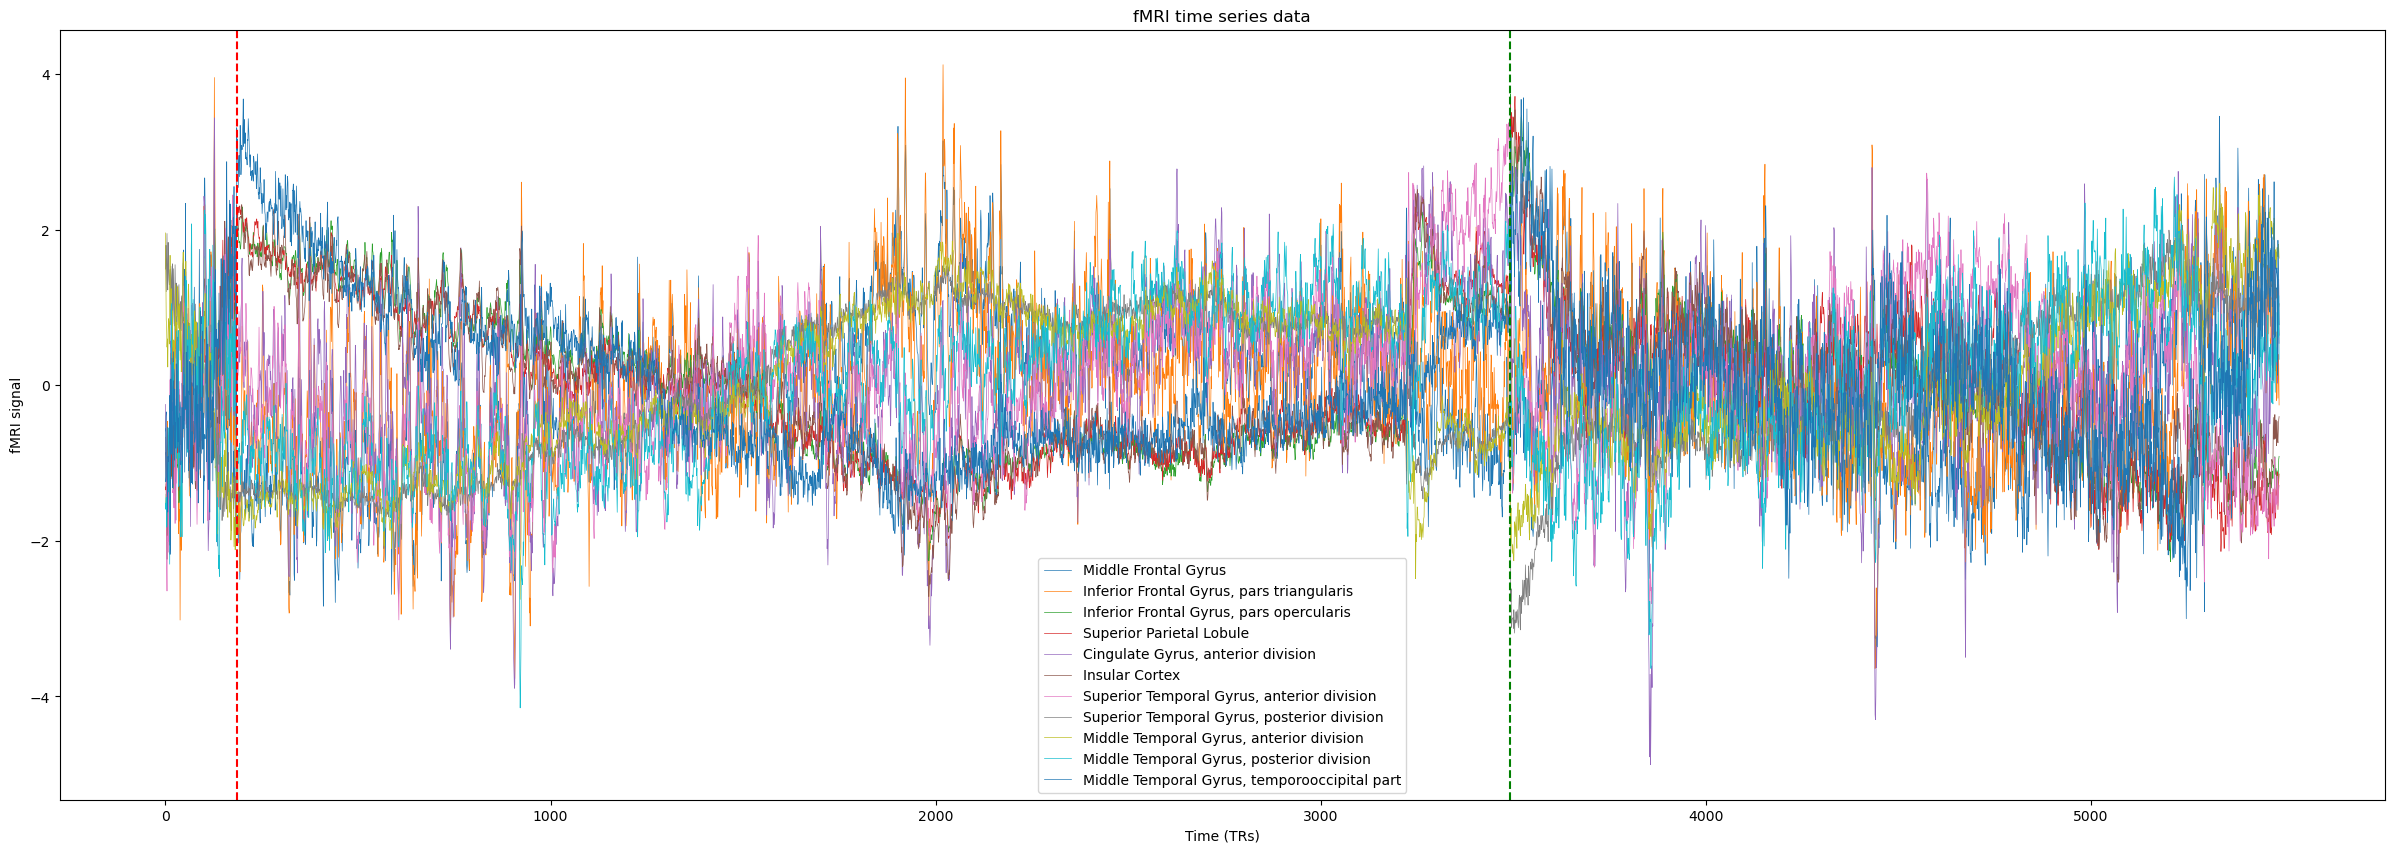

In [6]:
fig = plt.figure()
fig.set_size_inches(30, 10)

# Plot each time series and store the line objects
lines = []
lines.append(plt.plot(time_series[:,4], linewidth=0.5, label=labels[4])[0])
lines.append(plt.plot(time_series[:,5], linewidth=0.5, label=labels[5])[0])
lines.append(plt.plot(time_series[:,6], linewidth=0.5, label=labels[6])[0])
lines.append(plt.plot(time_series[:,18], linewidth=0.5, label=labels[18])[0])
lines.append(plt.plot(time_series[:,29], linewidth=0.5, label=labels[29])[0])
lines.append(plt.plot(time_series[:,2], linewidth=0.5, label=labels[2])[0])
lines.append(plt.plot(time_series[:,9], linewidth=0.5, label=labels[9])[0])
lines.append(plt.plot(time_series[:,10], linewidth=0.5, label=labels[10])[0])
lines.append(plt.plot(time_series[:,11], linewidth=0.5, label=labels[11])[0])
lines.append(plt.plot(time_series[:,12], linewidth=0.5, label=labels[12])[0])
lines.append(plt.plot(time_series[:,13], linewidth=0.5, label=labels[13])[0])

# Create the legend using the line objects and corresponding labels
plt.legend(handles=lines)

plt.xlabel('Time (TRs)')
plt.ylabel('fMRI signal')
plt.title('fMRI time series data')
plt.axvline(x=185, color='r', linestyle='--')
plt.axvline(x=185+3307, color='g', linestyle='--')
plt.show()

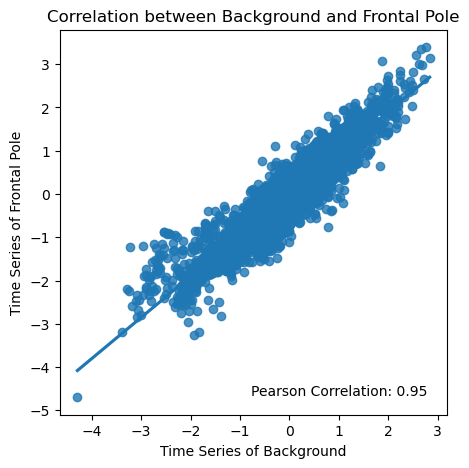

In [7]:
fig = plt.figure()
plt.scatter(time_series[:,0], time_series[:,1], alpha=0.05, s=1)
plt.xlabel('Time Series of '+labels[0])
plt.ylabel('Time Series of '+labels[1])
plt.title('Correlation between '+labels[0]+' and '+labels[1])
sns.regplot(x=time_series[:,0], y=time_series[:,1])
fig.set_size_inches(5, 5)
correlation = np.corrcoef(time_series[:,0], time_series[:,1])[0, 1]
plt.text(0.95, 0.05, 'Pearson Correlation: {:.2f}'.format(correlation), transform=plt.gca().transAxes, ha='right')
plt.show()


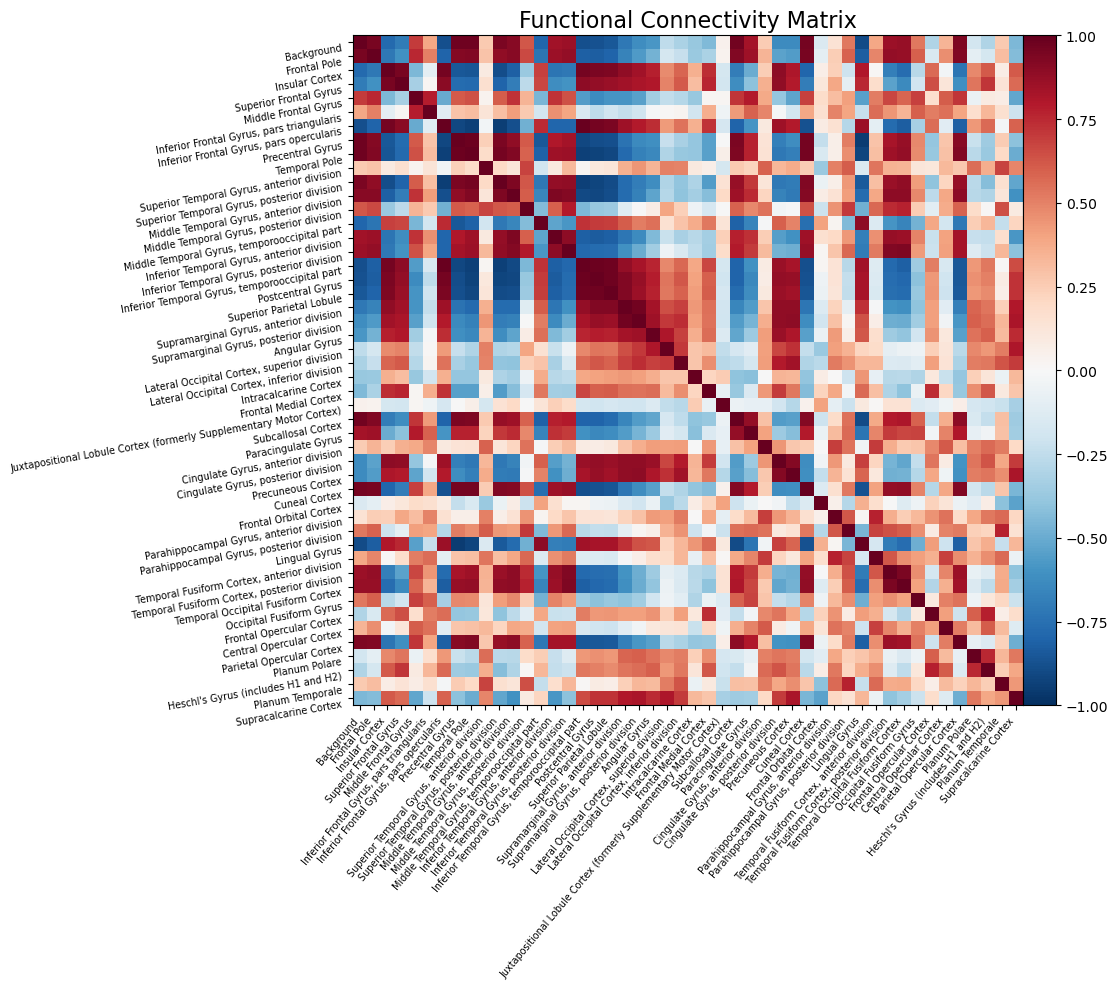

<Figure size 1500x1000 with 0 Axes>

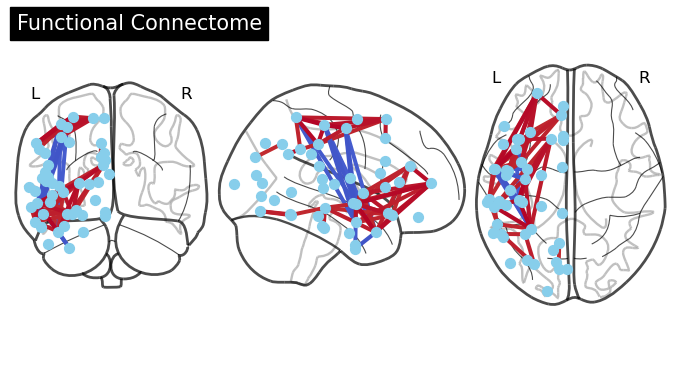

In [8]:
# Compute the correlation matrix
correlation_measure = connectome.ConnectivityMeasure(kind='correlation') #instanciando a classe
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Ensure the number of labels matches the number of regions
num_regions = correlation_matrix.shape[0]
if len(labels) > num_regions:
    labels = labels[:num_regions]

# Plot the correlation matrix with labels
fig, ax = plt.subplots(figsize=(12, 10))
plotting.plot_matrix(correlation_matrix, 
                     figure=fig, 
                     labels=labels, 
                     vmax=1, 
                     vmin=-1, 
                     title='Functional Connectivity Matrix')
plt.show()

# Visualize the connectome as a graph
fig = plt.figure()
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)
plotting.plot_connectome(correlation_matrix, 
                         coords, 
                         edge_threshold="95%", 
                         title='Functional Connectome', 
                         node_color='skyblue', 
                         edge_cmap='coolwarm')
fig.set_size_inches(15, 10)
plt.show()

### Network Connectome

In [9]:
def fisher_z_transform_lower_triangle(corr_matrix):
    # Ensure the input is a numpy array
    corr_matrix = np.array(corr_matrix)
    z_matrix = np.copy(corr_matrix)
    
    # Get the number of rows (or columns) in the matrix
    n = corr_matrix.shape[0]
    
    # Apply Fisher Z-transformation to the lower triangle (excluding the diagonal)
    for i in range(1, n):
        for j in range(i):
            z_matrix[i, j] = np.arctanh(corr_matrix[i, j])
            
    
    return z_matrix

# Example usage
corr_matrix = np.array([
    [1.0, 0.5, -0.3],
    [0.5, 1.0, 0.2],
    [-0.3, 0.2, 1.0]
])

z_matrix = fisher_z_transform_lower_triangle(corr_matrix)
print(z_matrix)

[[ 1.          0.5        -0.3       ]
 [ 0.54930614  1.          0.2       ]
 [-0.3095196   0.20273255  1.        ]]


In [14]:
def functional_conectivity(network_name, fmri_img, peak_coords, radius = 6, matrix_plot = False, connectome_plot = False, file=False):

    # Create 6mm spheres around these coordinates
    spheres_masker = input_data.NiftiSpheresMasker(seeds=peak_coords, radius=radius, standardize=True)
    time_series = spheres_masker.fit_transform(fmri_img) # Extract time series data for each sphere

    # Compute the functional connectome using ConnectivityMeasure
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

    # Plot the correlation matrix with labels
    if matrix_plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        plotting.plot_matrix(correlation_matrix, 
                            figure=fig, 
                            vmax=1, 
                            vmin=-1, 
                            title=network_name+': FC (Avg Correlation: {:.2f})'.format(np.mean(abs(correlation_matrix))))
        plt.show()

    #Visualize the connectome as a graph
    if connectome_plot:
        fig = plt.figure()
        coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)
        plotting.plot_connectome(correlation_matrix, 
                                peak_coords, 
                                edge_threshold="95%", 
                                title=network_name+': Functional Connectome', 
                                node_color='skyblue', 
                                edge_cmap='coolwarm')
        fig.set_size_inches(15, 10)
        plt.show()
    
    # Return the correlation matrix
    if file:
        return correlation_matrix

##### (1) Networks study: Inter‐ and intra‐subject similarity in network functional connectivity across a full narrative movie

In [11]:
df_networks = pd.read_csv("/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_derived/mni_space_of_networks.csv")
df_networks.head()

,network,node number,x,y,z,name,description
0,AM,1,-1,-53,21,Autobiographical memory,A central domain involved in a core network li...
1,AM,2,-26,-28,-17,Autobiographical memory,A central domain involved in a core network li...
2,AM,3,-49,-61,31,Autobiographical memory,A central domain involved in a core network li...
3,AM,4,-2,51,-11,Autobiographical memory,A central domain involved in a core network li...
4,AM,5,-60,-9,-18,Autobiographical memory,A central domain involved in a core network li...


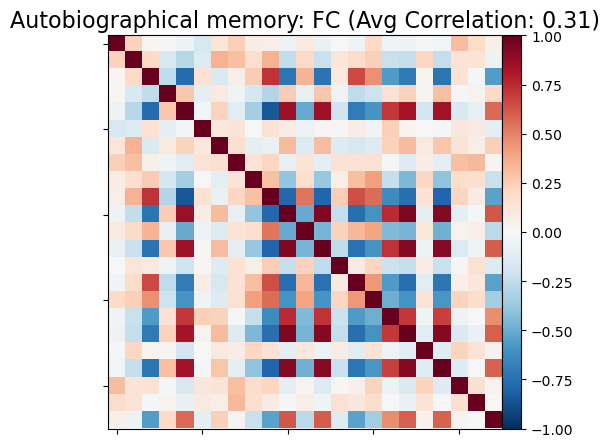

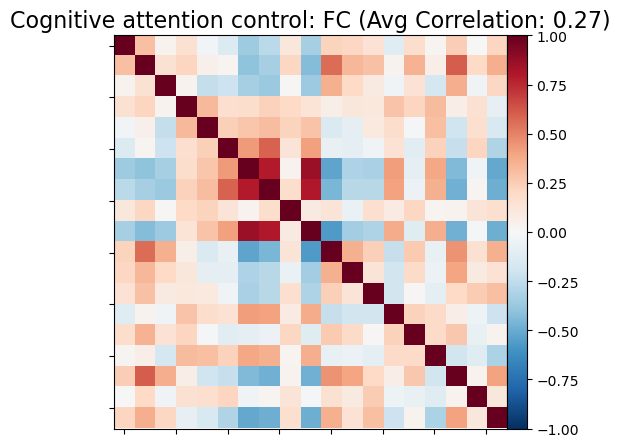

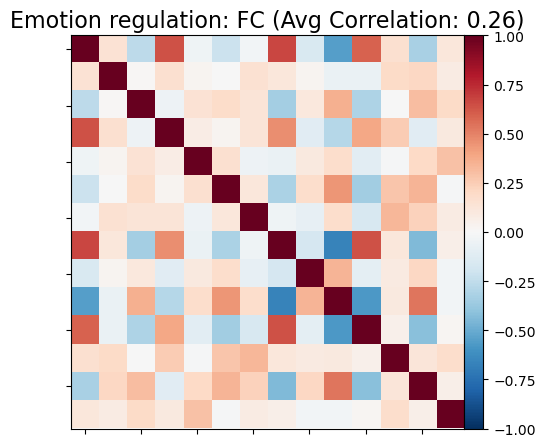

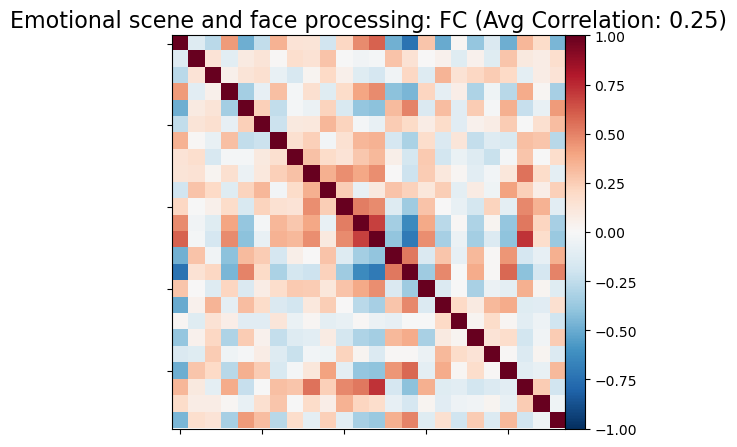

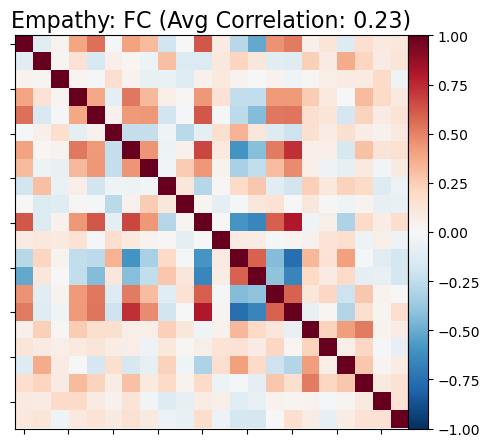

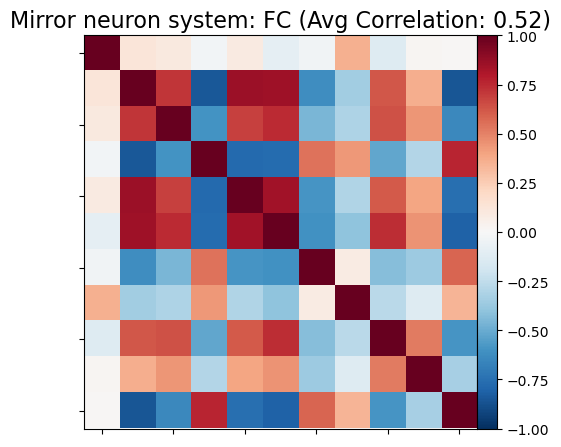

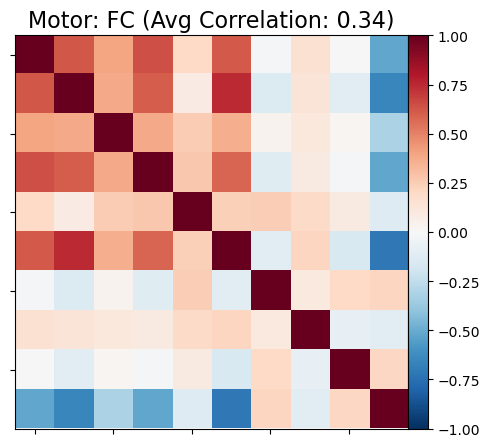

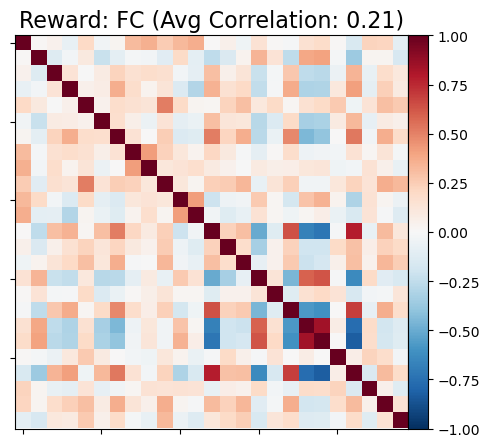

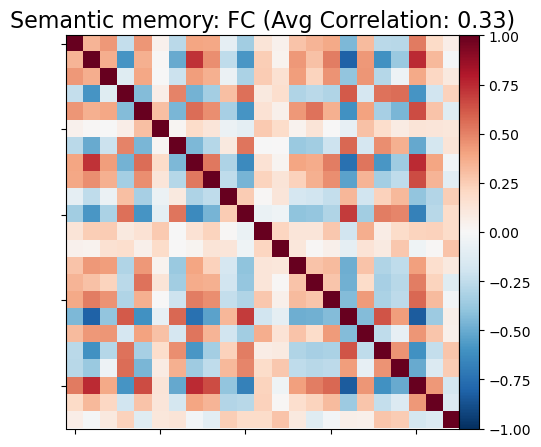

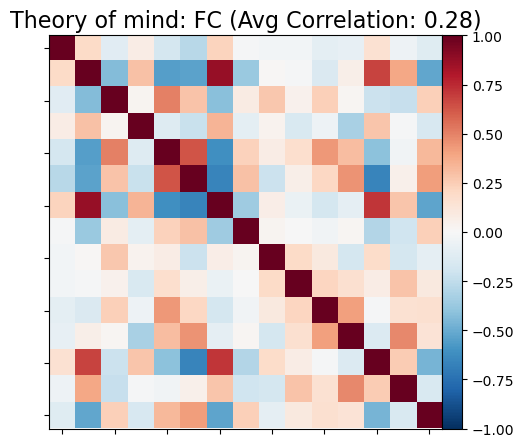

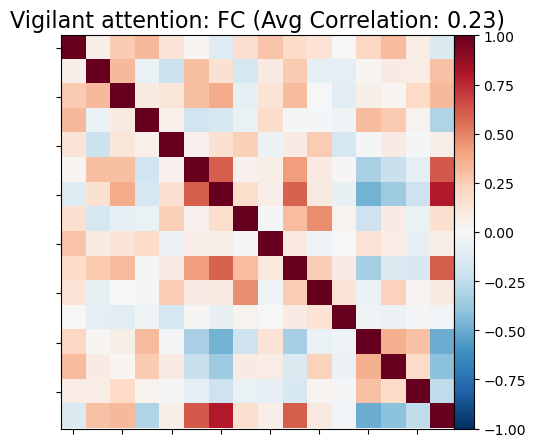

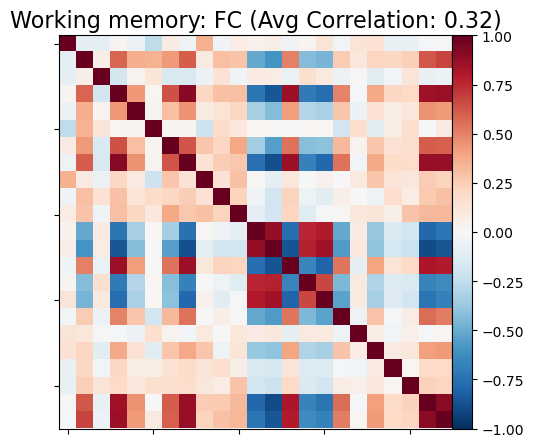

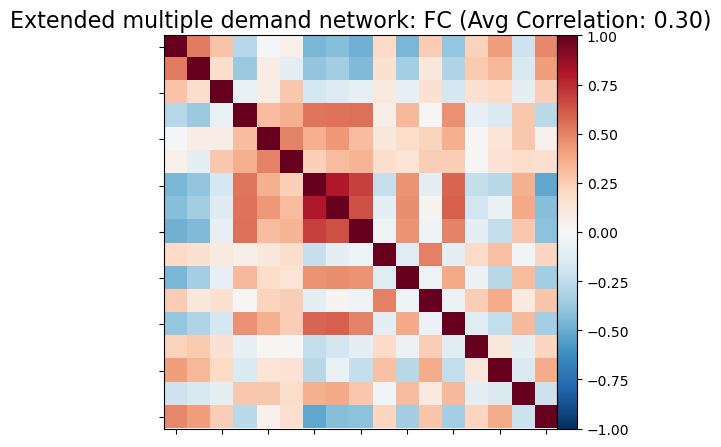

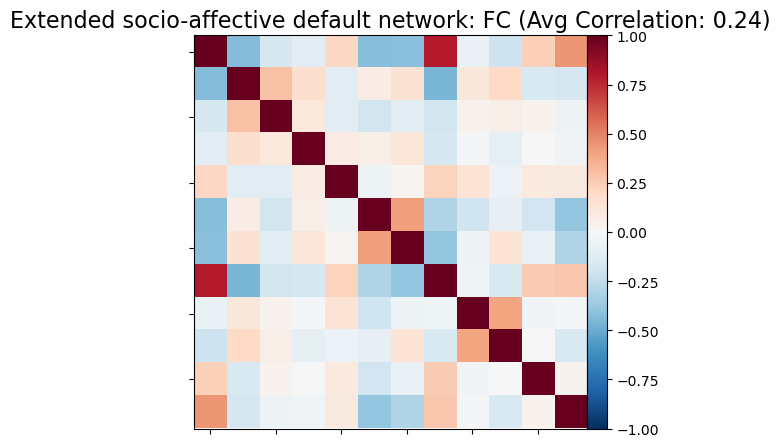

In [15]:
fmri_img = nib.load(fmri_path1)

for network, group in df_networks.groupby('network'):
    peak_coords = group[['x', 'y', 'z']].values
    network_name = group[['name']].values[0][0]
    radius = 6
    while True:
        try:
            functional_conectivity(network_name=network_name, 
                                    fmri_img=fmri_img, 
                                    peak_coords=peak_coords, 
                                    radius=radius,
                                    matrix_plot = True, 
                                    connectome_plot = False)
            break
        except ValueError as e:
            if "Overlap detected between spheres" in str(e):
                radius -= 1
                if radius < 1:
                    raise ValueError("Cannot reduce radius further to avoid overlap")
            else:
                raise e